In [2]:
import numpy as np
import torch
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
# Create a toy dataset to work with,  we want each point to have a position in R2 and an orientation
# For example,  let's make the 'force dataset' where each point has a position and an orientation
# And one hidden feature which depends on the positions and

In [6]:
def make_one_graph(num_points):

    x_pos = np.random.rand(num_points)
    x_pos = np.sort(x_pos)

    y_pos = np.random.rand(num_points)
    angle = np.random.rand(num_points)*2*np.pi

    data = np.column_stack((x_pos, y_pos, angle))

    forces = np.zeros(data.shape[0])

    init_feature = np.random.rand()
    forces[0] = init_feature

    for n in range(1,  num_points):
        angular_component =np.cos(data[:, 2])
        angular_component = np.where(angular_component < 0, 0, angular_component)

        x_diff = data[n, 0] - data[:, 0]
        y_diff = data[n, 1] - data[:, 1]
        distance = np.sqrt(x_diff**2 + y_diff**2)
        new_force = (forces*angular_component*distance).sum()
        forces[n] = new_force

    data = np.column_stack((data, forces))

    return data

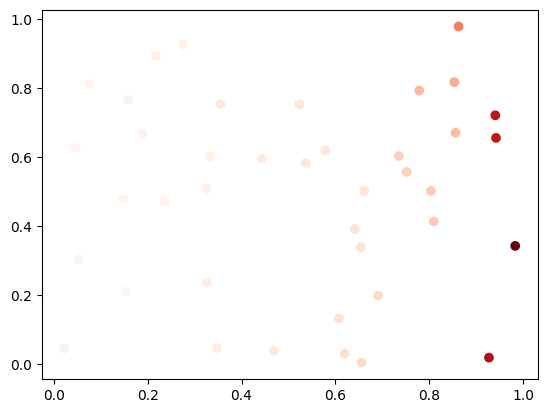

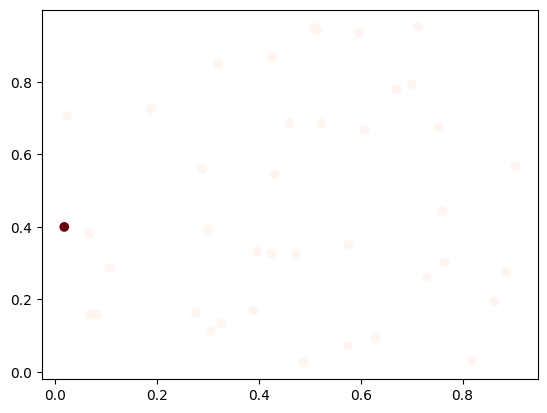

In [7]:
data = make_one_graph(num_points=40)
fig, ax = plt.subplots()

ax.scatter(data[:, 0], data[:, 1], c=data[:, 3], cmap="Reds")

In [8]:
def random_points_generator(choices=(30, 40, 50)):
    return np.random.choice(choices)

def make_dataset(num_graphs, num_points_generator):
    frames = []
    for n in range(num_graphs):
        num_points = num_points_generator()
        data = make_one_graph(num_points)

        df = pd.DataFrame(data)
        df['graph_id'] = n
        frames.append(df)
    return pd.concat(frames)

In [9]:
dataset = make_dataset(30, random_points_generator)

### Need to give the raw data a steerable representation

In [10]:
df = pd.DataFrame(data, columns=['x', 'y', 'theta', 'v'])

In [11]:
# First, let's convert this to be a complex number
theta, v = df[['theta', 'v']].iloc[0]
complex = v*np.exp(1j*theta)

In [12]:
class Complex:

    def __init__(self, r, theta):
        assert r >= 0
        self.r = r
        self.theta = theta % np.pi*2

    def __repr__(self):
        return f"{self.r}*exp[i {self.theta}]"

    @property
    def euc_form(self):
        # Python natively uses Euclidean form
        return self.r*np.exp(1j*self.theta)

    @property
    def real(self):
        return self.r * np.cos(self.theta)

    @property
    def im(self):
        return self.r * np.sin(self.theta)

    @classmethod
    def from_euc(cls, z):
        r = abs(z)
        theta = np.arctan2(z.imag, z.real)

        return cls(r, theta)

In [13]:
#Now, we can obtain a fourier representation of this up to some specified precision by using the analytic expression for the fourier transform on a circle c_k = e_k

def fourier_transform_point_function(z: Complex, precision):
    """Analytically obtain the fourier transform of a dirac function on S1 """
    indexes = np.arange(-precision, precision + 1)
    c = [z.r*np.cos(z.theta*k) for k in indexes]
    s = [z.r*np.sin(z.theta*k) for k in indexes]
    c = np.array(c)
    s = np.array(s)
    f_hat = np.column_stack((indexes, c, s))
    return f_hat

def inverse_transform(f_hat):
    components = lambda x: f_hat[:, 1]*np.cos(x*f_hat[:, 0]) + f_hat[:, 2]*np.sin(x*f_hat[:, 0])
    f = lambda x: 1/(2*np.pi)*components(x).sum()
    f = np.vectorize(f)
    return f

<BarContainer object of 13 artists>

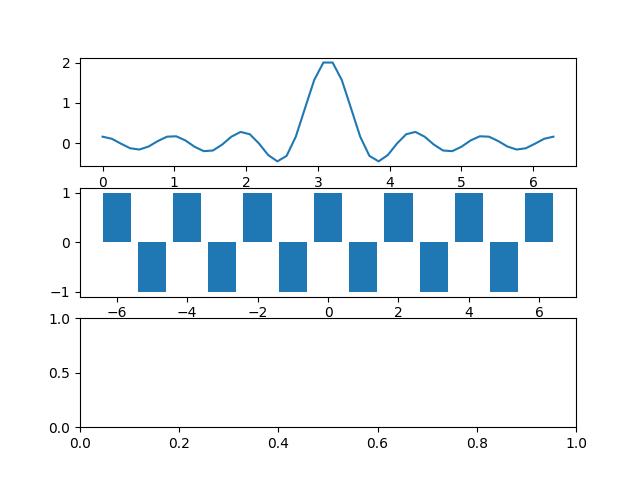

In [14]:
%matplotlib widget

from matplotlib.widgets import Slider

fig, ax = plt.subplots(3, 1)

axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='r',
    valmin=0.1,
    valmax=5,
    valinit=1,
)

r = 1
theta = np.pi/2
k = 6

z = Complex(r, theta)



z_hat = fourier_transform_point_function(z, k)
z_hat_hat = inverse_transform(z_hat)

xs = np.linspace(0, 2*np.pi)
ax[0].plot(xs, z_hat_hat(xs))
ax[1].bar(z_hat[:, 0], z_hat[:, 1])


#### Now define a transformer that works on these

In [ ]:
class AttentionBlock(torch.nn.Module):

    def __init__(self):
        super().__init__()

In [ ]:
class Base_SE2_Transformer(torch.nn.Module):
    """An abstract class! Need to subclass to produce invariants """
    def __init__(self, attention_hidden_units):
        super().__init__()

        self.attention_calculator = torch.nn

    def get_num_invariant_dimensions(self):
        raise NotImplementedError("Implement on subclass")

    def forward(self, x, ys):
        raise NotImplementedError() # TODO

    def get_positional_invariants(self, coords_1, coords_2):
        raise NotImplementedError("Create a subclass to implement this!")

class Euclidean_SE2_Transformer(Base_SE2_Transformer):

    def get_positional_invariant(self, coords_1, coords_2):
        x1, y1, theta1 = coords_1
        x2, y2, theta2 = coords_2

        x_diff = x1 - x2
        y_diff = y1 - y2
        return np.sqrt(x_diff**2 + y_diff**2)

    def get_num_invariant_dimensions(self):
        return 1

class FullyExpressive_SE2_Transformer(Base_SE2_Transformer):

    def get_positional_invariants(self, coords_1, coords_2):
        x1, y1, theta1 = coords_1
        x2, y2, theta2 = coords_2

        x_diff = x1 - x2
        y_diff = y1 - y2
        angle_diff = theta2 - theta1
        return np.sqrt(x_diff**2 + y_diff**2), angle_diff


